# Definições
Esse notebook irá analisar dados da estação A871, na cidade de Japira, no Paraná, de 2008 a 2023. O propósito aqui é realizar o EDA dos dados e, como output, obter alguams conclusões.

### Possíveis análises:
- Medir o nivel de radiação por ano, mes e horário do dia;
- Confirmar se há relação entre as categorias criadas (hue) com a radiação;
- Verificar estatísticas básicas (quantidades de nulls, media, desvio padrão, etc);
- Remoção de colunas desnecessárias;
- Feature engineering (juntar dois campos, criar campos category, etc)
- Remoção de Outliers

### Import das bibliotecas

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.special import expit
from scipy.stats import zscore
from pandas.errors import SettingWithCopyWarning
import os
from os import listdir
from os import system

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)


sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

### Métodos auxiliares

In [2]:
def getSigmoid():
    arr = np.arange(0, 1, 0.02)
    np.hstack(np.vstack(arr))
    def sigmoid(x):
        return 1/(1+expit(-x))
    
    sigmoid(arr)
    sns.scatterplot(x=arr, y=sigmoid(arr))

def get_files(n=1, lazy=True):
    cwd = os.getcwd()
    
    dict_data = {}
    
    listdir(cwd + "/data/estacoes_solares/BDM_INMET/")
    list_files = [x for x in listdir(cwd + "/data/estacoes_solares/BDM_INMET/") if ".csv" in x]

    if n:
        _range = list_files[0:n]
    else:
        _range = list_files
    
    for i in _range:
        # print("Processando arquivo " + i)
        
        code = i.split("_")[1]
        head = os.popen("head -10 data/estacoes_solares/BDM_INMET/" + i).read()

        if lazy:
            data = "data/estacoes_solares/BDM_INMET/"+i
        else:
            data = pd.read_csv("data/estacoes_solares/BDM_INMET/"+i, sep=";", skiprows=10)
        
        dict_data[code] = [head, data]

    return dict_data

def getDictToRenameDataFrame(list_columns):
    list_columns_new = []
    for i in list_columns: 
        list_columns_new.append(str
              .lower(i)
              .replace(" ", "_")
              . replace("(", "_")
              .replace(")", "")
              .replace("/", "")
              .replace("²", "2")
              .replace("°", "")
              .replace("%", "perc")
              .replace("._", "_")
              .replace(".", "_")
              .replace("__", "_")
              .replace("_-_", "_")
              .replace(",_", "_")
             )
    
    return dict(zip(list_columns, list_columns_new))

def renameDatasetColumns(df):
    list_columns = df.columns

    list_dict_to_rename = getDictToRenameDataFrame(list_columns)
    return df.rename(columns=list_dict_to_rename).drop(["unnamed:_22"], axis=1)

def hour_transform(n):
    if len(str(n)) == 4:
        return str(n)[0:2] + ":" + str(n)[2:] + ":00"
    elif len(str(n)) == 3:
        return "0" + str(n)[0:1] + ":" + str(n)[1:] + ":00"
    elif n == 0:
        return "00:00:00"

def create_datetime_feature(df):
    df["hora_medicao"] = df["hora_medicao"].apply(hour_transform)
    df["data_hora_str"] = df["data_medicao"] + " " + df["hora_medicao"]
    df["data_hora"] = pd.to_datetime(df["data_hora_str"])
    df["hora"] = df['data_hora'].dt.hour
    
    return df.drop(["data_hora_str", "data_medicao", "hora_medicao"], axis=1)

def create_split_date_features(df):
    df["dia"] = df["data_hora"].dt.day
    df["mes"] = df["data_hora"].dt.month
    df["ano"] = df["data_hora"].dt.year

    return df

def create_category(column, df):
    labels = ["A", "B", "C", "D"]
    classes = df.describe()[column][3:8].values

    if classes[1] == 0:
        classes[1] = classes[1]+0.1
        print("aqui")
    print(classes)
    
    return pd.cut(x = df[column],
         bins = classes,
         labels = labels,
         include_lowest = True)

def removeNulls(df, col):
    return df[df[col].notnull()]

def pre_processing(df):
    renameDatasetColumns(df)

def load(path):
    return pd.read_csv(path, sep=";", skiprows=10)

def get_perc_nulls(df):
    return (df.isnull().sum()/(len(df)))*100

### Obtendo os dados
Por uma qestão de recursos, não foi possivel carregar todas as estações em um dicionário, por exemplo. Sendo assim, o método `get_files` tem um parâmetro que determina a condição de "lazy", ou seja, eu carrego somente os paths dos arquivos e vou carregando na memória somente o que usarei. Além disso, podemos especificar a quantidade de arquivos através do parâmetro `n`. 

In [3]:
dict_data = get_files(n=None)

In [4]:
print(dict_data.keys())

dict_keys(['A316', 'A419', 'A853', 'A372', 'A326', 'A225', 'A348', 'A207', 'A319', 'A430', 'A358', 'A440', 'A305', 'A337', 'A340', 'A204', 'B806', 'A825', 'A446', 'A338', 'A331', 'A872', 'A301', 'A350', 'A330', 'A823', 'A333', 'A322', 'A821', 'A828', 'A346', 'A318', 'A349', 'A336', 'A343', 'A441', 'A308', 'A220', 'A411', 'A313', 'A846', 'A855', 'A237', 'A820', 'A874', 'A450', 'A218', 'A405', 'A341', 'A444', 'A436', 'A811', 'A363', 'A352', 'A217', 'A351', 'A320', 'A239', 'A224', 'A449', 'A205', 'A873', 'A409', 'A221', 'A843', 'A304', 'A238', 'A812', 'A055', 'A317', 'A807', 'A357', 'A345', 'A133', 'A437', 'A310', 'A452', 'A818', 'A835', 'A203', 'A822', 'A424', 'A407', 'A365', 'A404', 'A354', 'A417', 'A455', 'A328', 'A377', 'A309', 'A438', 'A306', 'A849', 'A206', 'A359', 'A361', 'A842', 'A824', 'A307', 'A420', 'A054', 'A219', 'B803', 'A127', 'A826', 'A332', 'A375', 'A362', 'B804', 'A311', 'A414', 'A827', 'A223', 'A329', 'A423', 'A875', 'A344', 'A840', 'A819', 'A850', 'A222', 'A401', 'A324

### Renomeando as colunas

In [5]:
df = renameDatasetColumns(load(dict_data["A871"][1]))

### Showing info data

In [6]:
print(dict_data["A871"][0])

Nome: JAPIRA
Codigo Estacao: A871
Latitude: -23.77333332
Longitude: -50.18055554
Altitude: 692.88
Situacao: Operante
Data Inicial: 2008-02-28
Data Final: 2023-09-10
Periodicidade da Medicao: Horaria




In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136176 entries, 0 to 136175
Data columns (total 22 columns):
 #   Column                                              Non-Null Count   Dtype  
---  ------                                              --------------   -----  
 0   data_medicao                                        136176 non-null  object 
 1   hora_medicao                                        136176 non-null  int64  
 2   precipitacao_total_horario_mm                       122820 non-null  float64
 3   pressao_atmosferica_ao_nivel_da_estacao_horaria_mb  123047 non-null  float64
 4   pressao_atmosferica_reduzida_nivel_do_mar_aut_mb    123037 non-null  float64
 5   pressao_atmosferica_max_na_hora_ant_aut_mb          122997 non-null  float64
 6   pressao_atmosferica_min_na_hora_ant_aut_mb          122997 non-null  float64
 7   radiacao_global_kjm2                                122936 non-null  float64
 8   temperatura_da_cpu_da_estacao_c                     123047 non-n

O dataset contém uma quantidade pequena de nulos. Neste caso, vamos remover os nulos com base na característica teórica mais importante, a radiação. Mas antes, vamos só ver a porcentagem de nulos por coluna.

In [8]:
get_perc_nulls(df)

data_medicao                                           0.000000
hora_medicao                                           0.000000
precipitacao_total_horario_mm                          9.807896
pressao_atmosferica_ao_nivel_da_estacao_horaria_mb     9.641200
pressao_atmosferica_reduzida_nivel_do_mar_aut_mb       9.648543
pressao_atmosferica_max_na_hora_ant_aut_mb             9.677917
pressao_atmosferica_min_na_hora_ant_aut_mb             9.677917
radiacao_global_kjm2                                   9.722712
temperatura_da_cpu_da_estacao_c                        9.641200
temperatura_do_ar_bulbo_seco_horaria_c                 9.641200
temperatura_do_ponto_de_orvalho_c                      9.760163
temperatura_maxima_na_hora_ant_aut_c                   9.677917
temperatura_minima_na_hora_ant_aut_c                   9.677917
temperatura_orvalho_max_na_hora_ant_aut_c              9.696275
temperatura_orvalho_min_na_hora_ant_aut_c             10.227206
tensao_da_bateria_da_estacao_v          

In [9]:
df_non_null = removeNulls(df, "radiacao_global_kjm2")

### Configurando campos de data e hora.
Como a coluna `data_medicao` e `hora_medicao` estão separadas e não são do tipo date/time, precisamos criar uma coluna que seja desse tipo. 

In [10]:
df_non_null_dt = create_datetime_feature(df_non_null)
df_non_null_dt = create_split_date_features(df_non_null_dt)

### Plot inicial dos dados

In [11]:
df_non_null_dt.head().T

,25,26,27,28,29
precipitacao_total_horario_mm,0.8,0.8,0.8,0.8,0.0
pressao_atmosferica_ao_nivel_da_estacao_horaria_mb,932.7,932.9,932.7,932.1,931.5
pressao_atmosferica_reduzida_nivel_do_mar_aut_mb,1011.409854,1011.851186,1011.718743,1011.124296,1010.529858
pressao_atmosferica_max_na_hora_ant_aut_mb,932.7,932.9,932.9,932.7,932.1
pressao_atmosferica_min_na_hora_ant_aut_mb,932.2,932.6,932.7,932.1,931.5
radiacao_global_kjm2,-3.527,-3.383,-2.833,-2.922,-2.955
temperatura_da_cpu_da_estacao_c,23.0,22.0,21.0,21.0,21.0
temperatura_do_ar_bulbo_seco_horaria_c,19.8,19.0,18.7,18.5,18.3
temperatura_do_ponto_de_orvalho_c,18.1,17.9,17.9,17.5,17.6
temperatura_maxima_na_hora_ant_aut_c,20.6,19.8,19.1,18.7,18.5


In [12]:
df = df_non_null_dt

### Algumas estatísticas e Outliers
Uma checagem rápida das estatísticas dos dados para detectar em um primeiro momento a presença de outliers. 

In [13]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
precipitacao_total_horario_mm,122709.0,0.153682,0.0,0.0,0.0,0.0,54.4,1.169678
pressao_atmosferica_ao_nivel_da_estacao_horaria_mb,122936.0,936.542085,923.0,934.0,936.4,939.0,950.4,3.601369
pressao_atmosferica_reduzida_nivel_do_mar_aut_mb,122926.0,1015.424197,999.727749,1012.122618,1015.086192,1018.574932,1031.803242,4.656222
pressao_atmosferica_max_na_hora_ant_aut_mb,122886.0,936.80209,923.0,934.3,936.6,939.2,950.5,3.577683
pressao_atmosferica_min_na_hora_ant_aut_mb,122886.0,936.282052,922.8,933.8,936.1,938.7,950.2,3.616533
radiacao_global_kjm2,122936.0,731.30768,-6.957,-3.54,28.6255,1349.68225,4240.856,1048.128858
temperatura_da_cpu_da_estacao_c,122936.0,21.958125,1.0,18.0,22.0,26.0,40.0,5.341006
temperatura_do_ar_bulbo_seco_horaria_c,122936.0,20.429985,0.1,17.3,20.3,23.5,37.3,4.76105
temperatura_do_ponto_de_orvalho_c,122774.0,14.714442,-10.0,12.1,15.2,18.0,24.1,4.126603
temperatura_maxima_na_hora_ant_aut_c,122886.0,21.033127,1.0,17.7,20.8,24.3,37.9,4.916072


#### Radiação
O desvio padrão da radiação está muito alto em relação a média. Vamos fazer algumas análises e tentar chegar numa conclusão.

##### Percentil

In [14]:
for i in range(0, 101):
    value_str = str(i)

    if len(value_str) == 1:
        value_str = "0.0"+value_str
    
    elif len(value_str) == 2:
        value_str = "0."+value_str
    else:
        value_str = "1.0"
    
    double_value = float(value_str) 
    print(value_str, df["radiacao_global_kjm2"].quantile(double_value))
    

0.00 -6.957
0.01 -3.54
0.02 -3.54
0.03 -3.54
0.04 -3.54
0.05 -3.54
0.06 -3.54
0.07 -3.54
0.08 -3.54
0.09 -3.54
0.10 -3.54
0.11 -3.54
0.12 -3.54
0.13 -3.54
0.14 -3.54
0.15 -3.54
0.16 -3.54
0.17 -3.54
0.18 -3.54
0.19 -3.54
0.20 -3.54
0.21 -3.54
0.22 -3.54
0.23 -3.54
0.24 -3.54
0.25 -3.54
0.26 -3.536
0.27 -3.529
0.28 -3.512
0.29 -3.482
0.30 -3.449
0.31 -3.395
0.32 -3.328
0.33 -3.246
0.34 -3.152
0.35 -3.03575
0.36 -2.903
0.37 -2.751050000000003
0.38 -2.587
0.39 -2.412
0.40 -2.222
0.41 -2.006
0.42 -1.774
0.43 -1.5039000000000087
0.44 -1.1735999999999984
0.45 -0.787
0.46 -0.28189999999999416
0.47 0.940449999999997
0.48 4.850199999999982
0.49 14.304500000000015
0.50 28.625500000000002
0.51 42.8227
0.52 60.51960000000001
0.53 83.56265
0.54 115.0608000000002
0.55 149.182
0.56 184.65280000000058
0.57 222.79909999999987
0.58 263.80029999999823
0.59 305.6727499999999
0.60 355.825
0.61 408.6779999999991
0.62 463.80579999999986
0.63 523.8731000000002
0.64 578.1206000000008
0.65 632.19825
0.66 696.10

Como vimos, mudanças significtiva nos dados ocorrem a partir do 47th percentil. Vamos agora ordenar para ver se o maior valor está muito diferentes dos próximos.

In [15]:
df.sort_values(by="radiacao_global_kjm2", ascending=False)["radiacao_global_kjm2"].head(10)

25649     4240.856
103648    4191.340
6737      4169.149
24064     4168.816
104032    4166.618
94456     4147.243
95440     4109.601
129903    4099.226
24616     4096.432
112431    4096.203
Name: radiacao_global_kjm2, dtype: float64

In [16]:
df.sort_values(by="radiacao_global_kjm2", ascending=True)["radiacao_global_kjm2"].head(10)

6098     -6.957
130707   -6.720
66176    -3.540
66177    -3.540
66191    -3.540
66192    -3.540
66193    -3.540
66194    -3.540
66196    -3.540
66200    -3.540
Name: radiacao_global_kjm2, dtype: float64

Aparentemente, não há outliers, vamos calcular o z-score para essa coluna: `Z = (X−µ) ÷ σ`

In [17]:
df[["radiacao_global_kjm2"]].apply(zscore).sort_values(by="radiacao_global_kjm2", ascending=False)

,radiacao_global_kjm2
25649,3.348408
103648,3.301165
6737,3.279993
24064,3.279675
104032,3.277578
...,...
59405,-0.701107
59496,-0.701107
59497,-0.701107
130707,-0.704141


O z-score não mostrou nada muito atipico. Vamos plotar o histograma.

<Axes: ylabel='Frequency'>

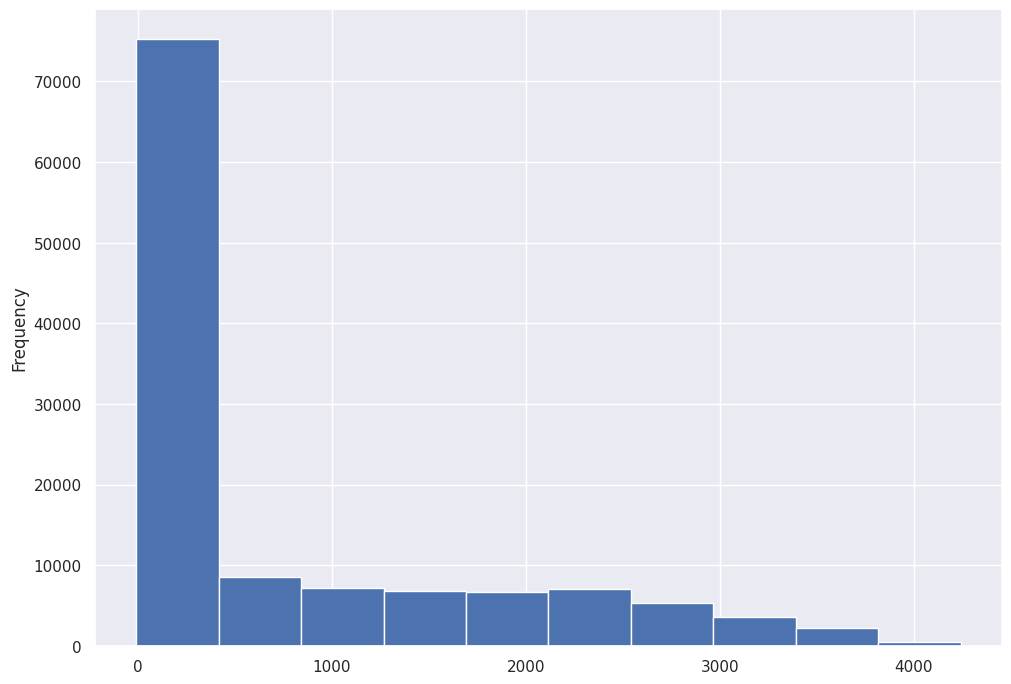

In [18]:
df["radiacao_global_kjm2"].plot.hist()

In [19]:
df[df["radiacao_global_kjm2"]>0]["radiacao_global_kjm2"].count()

65896

In [20]:
df[df["radiacao_global_kjm2"]>0]["radiacao_global_kjm2"].describe()

count    65896.000000
mean      1367.024497
std       1085.582743
min          0.001000
25%        345.577750
50%       1208.103000
75%       2246.720500
max       4240.856000
Name: radiacao_global_kjm2, dtype: float64

<Axes: ylabel='Frequency'>

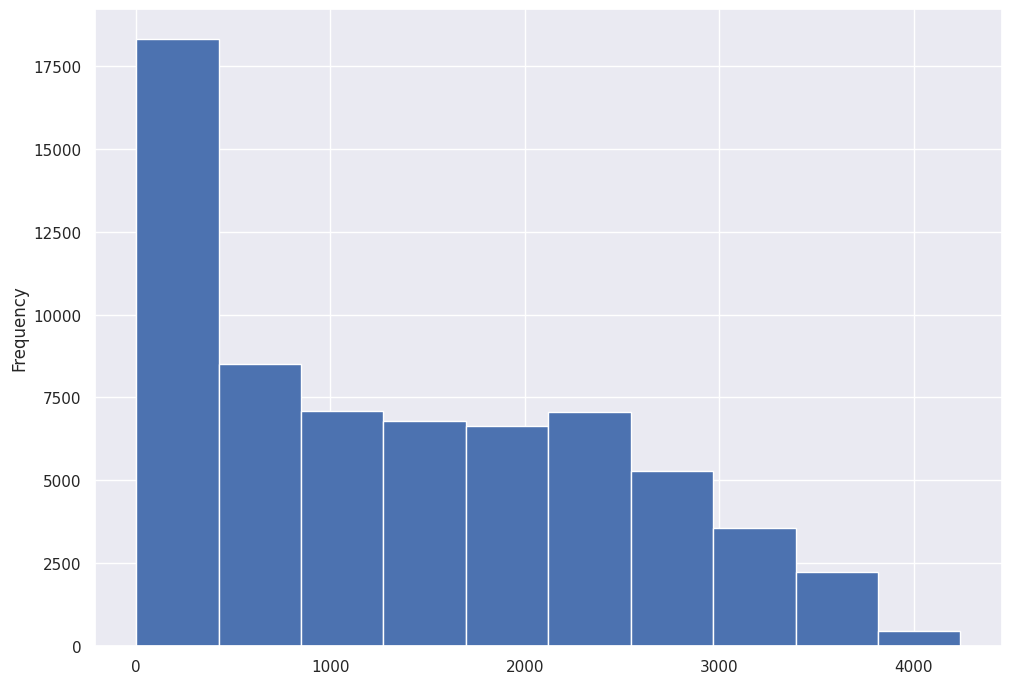

In [21]:
df[df["radiacao_global_kjm2"]>0]["radiacao_global_kjm2"].plot.hist()

Apesar do desbalanceamento dos dados, não se pode afirmar que a radiação tenha outliers. Portanto, não removeremos nenhum registro. Entretanto, podemos remover posteriormente apenas para ver o comportamento dos dados.

In [22]:
# df = df[df["radiacao_global_kjm2"]>0]

#### Vento
Aparentemente, a variável do vento contém alguns dados desbalanceados, como podemos ver aqui no histograma

<Axes: ylabel='Frequency'>

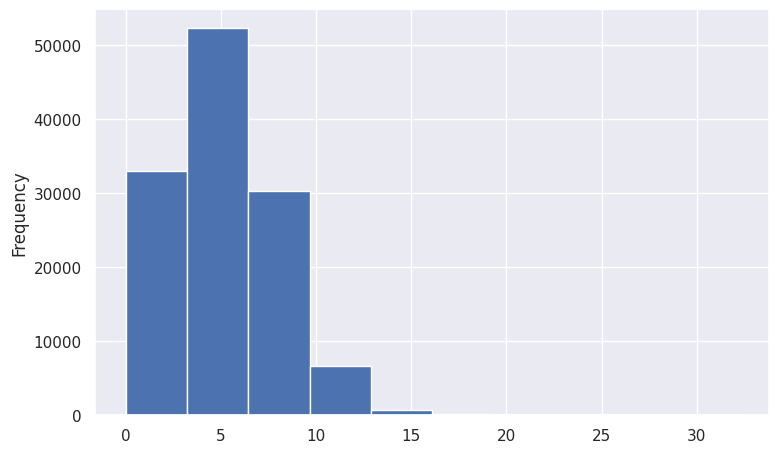

In [23]:
sns.set_theme(rc={'figure.figsize':(8.7,5.27)})
df["vento_rajada_maxima_ms"].plot.hist()

In [24]:
df[df["vento_rajada_maxima_ms"] > 15]["vento_rajada_maxima_ms"].count()

272

In [25]:
df = df[df["vento_rajada_maxima_ms"] <=15]

### Removendo colunas
A coluna `precipitacao_total_horario_mm` tem muitos zeros ou nulos, portanto, iremos remove-la.

In [26]:
df["precipitacao_total_horario_mm"].value_counts()

precipitacao_total_horario_mm
0.0     114172
0.2       2331
0.4        916
0.6        637
0.8        468
         ...  
31.0         1
25.8         1
20.6         1
30.8         1
44.4         1
Name: count, Length: 144, dtype: int64

<Axes: ylabel='Frequency'>

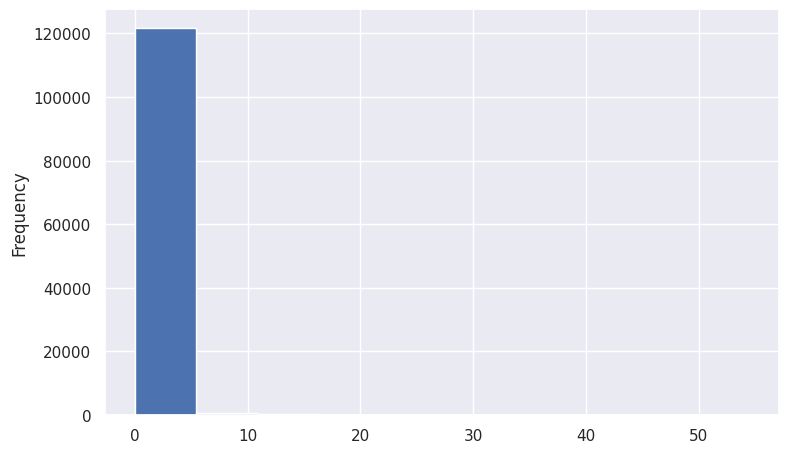

In [27]:
df["precipitacao_total_horario_mm"].plot.hist()

In [28]:
without_relevance = ["temperatura_do_ponto_de_orvalho_c",
                 "temperatura_orvalho_max_na_hora_ant_aut_c",
                 "temperatura_orvalho_min_na_hora_ant_aut_c",
                 "tensao_da_bateria_da_estacao_v",
                 "vento_direcao_horaria_gr__gr",
                 "vento_velocidade_horaria_ms"]

many_nulls_zeros = ["precipitacao_total_horario_mm"]

without_relevance.extend(many_nulls_zeros)

df = df.drop(without_relevance, axis=1)

### Feature engineering
Algumas colunas possuem comportamento similar. Portanto, podemos mescla-las em uma só. 

#### Atmo Press

In [29]:
join_press = [
            "pressao_atmosferica_ao_nivel_da_estacao_horaria_mb", 
            "pressao_atmosferica_reduzida_nivel_do_mar_aut_mb",
            "pressao_atmosferica_max_na_hora_ant_aut_mb",
            "pressao_atmosferica_min_na_hora_ant_aut_mb"
       ]
df[join_press].describe().T

,count,mean,std,min,25%,50%,75%,max
pressao_atmosferica_ao_nivel_da_estacao_horaria_mb,122590.0,936.545782,3.598800,923.000000,934.100000,936.400000,939.000000,950.400000
pressao_atmosferica_reduzida_nivel_do_mar_aut_mb,122580.0,1015.427270,4.654652,999.727749,1012.125471,1015.092604,1018.576672,1031.803242
pressao_atmosferica_max_na_hora_ant_aut_mb,122590.0,936.806028,3.576046,923.000000,934.300000,936.600000,939.200000,950.500000
pressao_atmosferica_min_na_hora_ant_aut_mb,122590.0,936.288288,3.612795,922.800000,933.800000,936.100000,938.800000,950.200000


In [30]:
df_local =  df[join_press]
df["press_atmo"] = df_local.mean(axis=1)
df = df.drop(join_press, axis=1)

#### Temperature

In [31]:
mean_temp = [
        "temperatura_do_ar_bulbo_seco_horaria_c",
        "temperatura_da_cpu_da_estacao_c", 
        "temperatura_maxima_na_hora_ant_aut_c",
        "temperatura_minima_na_hora_ant_aut_c"]

df[mean_temp].describe().T

,count,mean,std,min,25%,50%,75%,max
temperatura_do_ar_bulbo_seco_horaria_c,122590.0,20.433451,4.764524,0.1,17.3,20.3,23.5,37.3
temperatura_da_cpu_da_estacao_c,122590.0,21.956726,5.342340,1.0,18.0,22.0,26.0,40.0
temperatura_maxima_na_hora_ant_aut_c,122590.0,21.029101,4.916500,1.0,17.7,20.8,24.3,37.9
temperatura_minima_na_hora_ant_aut_c,122590.0,19.856747,4.599421,0.0,16.8,19.8,22.8,36.8


In [32]:
df_local =  df[mean_temp]
df["temperature"] = df_local.mean(axis=1)
df = df.drop(mean_temp, axis=1)

#### Humidity

In [33]:
mean_humidity = ["umidade_rel_max_na_hora_ant_aut_perc",
            "umidade_rel_min_na_hora_ant_aut_perc",
            "umidade_relativa_do_ar_horaria_perc"]

df[mean_humidity].describe().T

,count,mean,std,min,25%,50%,75%,max
umidade_rel_max_na_hora_ant_aut_perc,122572.0,75.348750,16.927407,7.0,64.0,79.0,90.0,99.0
umidade_rel_min_na_hora_ant_aut_perc,121665.0,69.784079,18.886621,7.0,56.0,72.0,86.0,99.0
umidade_relativa_do_ar_horaria_perc,122390.0,72.577637,17.979880,7.0,60.0,76.0,88.0,99.0


In [34]:
df_local =  df[mean_humidity]
df["humidity"] = df_local.mean(axis=1)
df = df.drop(mean_humidity, axis=1)

In [35]:
df.head()

,radiacao_global_kjm2,vento_rajada_maxima_ms,data_hora,hora,dia,mes,ano,press_atmo,temperature,humidity
25,-3.527,6.8,2008-02-29 01:00:00,1,29,2,2008,952.252463,20.775,88.666667
26,-3.383,7.3,2008-02-29 02:00:00,2,29,2,2008,952.562796,19.950,91.666667
27,-2.833,7.2,2008-02-29 03:00:00,3,29,2,2008,952.504686,19.375,94.333333
28,-2.922,7.4,2008-02-29 04:00:00,4,29,2,2008,952.006074,19.150,94.333333
29,-2.955,7.5,2008-02-29 05:00:00,5,29,2,2008,951.407464,19.025,95.333333


### Analise com datas
Aqui iremos plotar a radiação por data

#### Ano

In [36]:
df_year = df[["ano", "radiacao_global_kjm2"]].groupby(['ano']).mean().reset_index()

#### Média e desvio
Apenas para garantir que não temos uma discrepância entre média e desvio, vamos exibir por ano. 

In [37]:
df[["ano", "radiacao_global_kjm2"]].groupby(['ano'])\
['radiacao_global_kjm2'].agg(['mean','std'])

,mean,std
ano,,
2008,708.883698,1026.844038
2009,695.430903,1021.130410
2010,700.928905,1032.375902
2011,744.253388,1063.386588
2012,796.584386,1094.977331
2013,718.594582,1041.308111
2014,785.930428,1079.966315
2015,692.005088,1010.636478
2016,736.851592,1060.852543


<Axes: xlabel='ano', ylabel='radiacao_global_kjm2'>

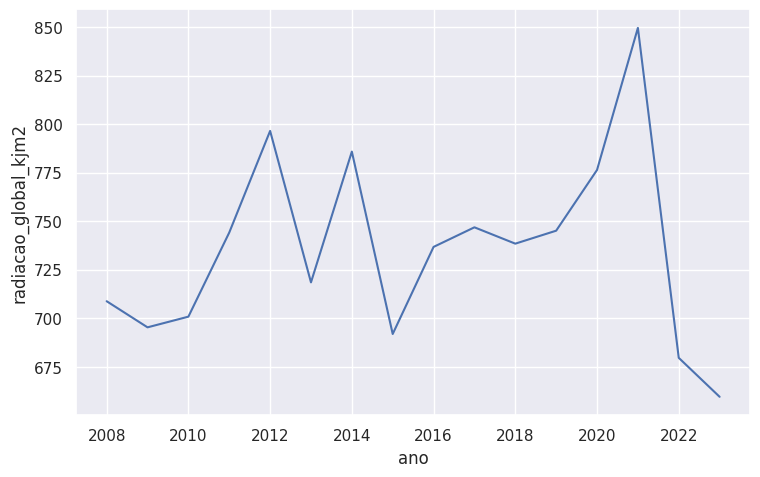

In [39]:
sns.lineplot(data=df_year, x=df_year["ano"], y=df_year["radiacao_global_kjm2"])

#### Mes

In [40]:
df_month = df[["mes", "radiacao_global_kjm2"]].groupby(['mes']).mean().reset_index()

<Axes: xlabel='mes', ylabel='radiacao_global_kjm2'>

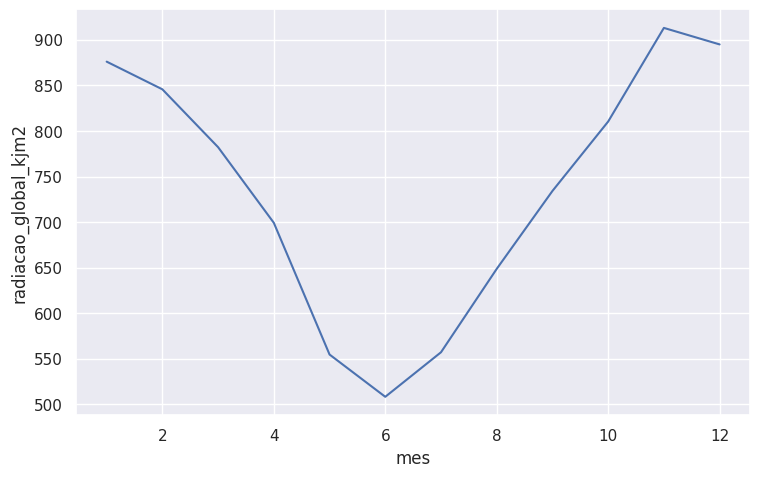

In [41]:
sns.lineplot(data=df_month, x=df_month["mes"], y=df_month["radiacao_global_kjm2"])

#### Hora

In [42]:
df_hour = df[["hora", "radiacao_global_kjm2"]].groupby(['hora']).mean().reset_index()

<Axes: xlabel='hora', ylabel='radiacao_global_kjm2'>

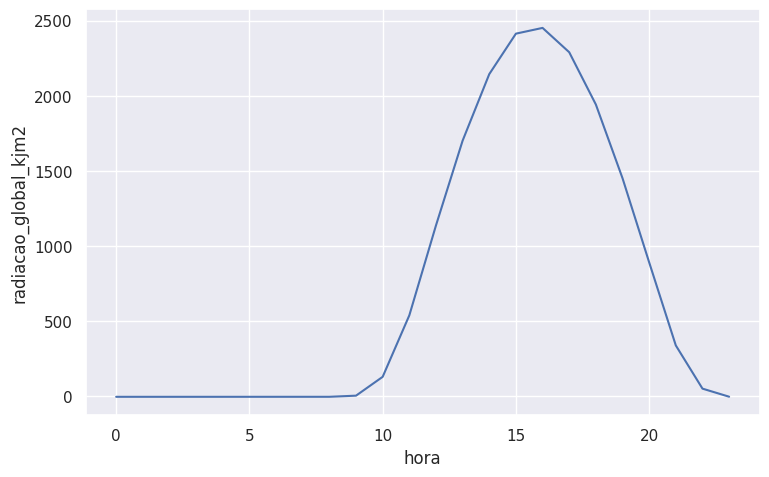

In [43]:
sns.lineplot(data=df_hour, x=df_hour["hora"], y=df_hour["radiacao_global_kjm2"])

#### Hora com o vento como `hue`

In [44]:
df_hour_wind = df[[
    "hora", 
    "radiacao_global_kjm2", 
    "vento_rajada_maxima_ms"]]\
.fillna(0)

df_hour_wind["wind_catg"] = create_category("vento_rajada_maxima_ms", df_hour_wind)


[ 0.   3.1  5.1  6.9 15. ]


<Axes: xlabel='hora', ylabel='radiacao_global_kjm2'>

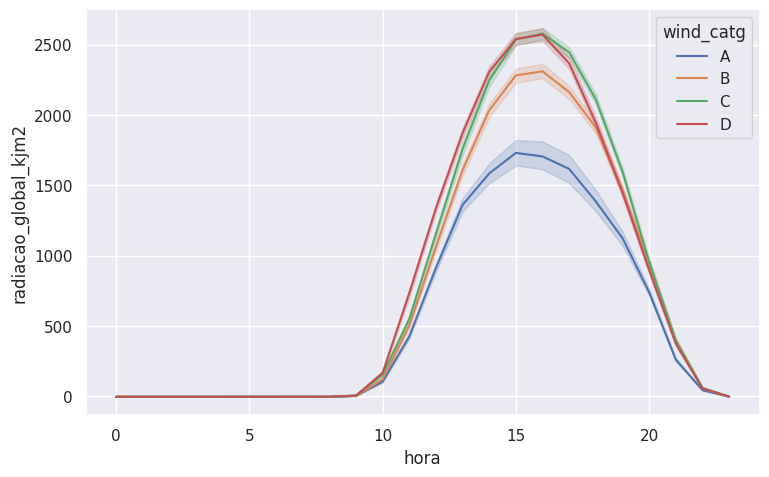

In [45]:
sns.lineplot(data=df_hour_wind, x=df_hour_wind["hora"], y=df_hour_wind["radiacao_global_kjm2"], hue=df_hour_wind["wind_catg"])

#### Hora com a pressão atmo. como `hue`

In [46]:
df_hour_press = df[[
    "hora", 
    "radiacao_global_kjm2", 
    "press_atmo"]]\
.fillna(0)

df_hour_press["press_catg"] = create_category("press_atmo", df_hour_press)

[934.46666667 953.58519463 956.05268025 958.8695295  970.56218975]


<Axes: xlabel='hora', ylabel='radiacao_global_kjm2'>

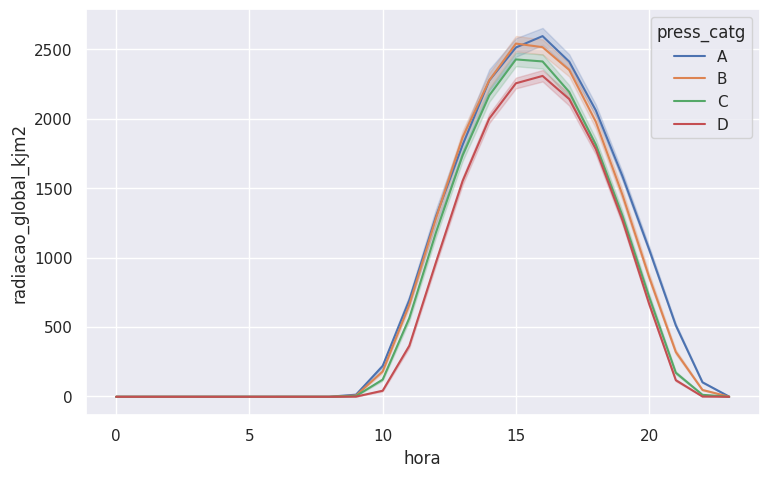

In [47]:
sns.lineplot(data=df_hour_press, x=df_hour_press["hora"], y=df_hour_press["radiacao_global_kjm2"], hue=df_hour_press["press_catg"])

#### Hora com a temperatura como `hue`

In [48]:
df_temp = df[[
    "hora", 
    "radiacao_global_kjm2", 
    "temperature"]]\
.fillna(0)

df_temp["temp_catg"] = create_category("temperature", df_temp)

[ 0.825 17.55  20.6   24.025 37.95 ]


<Axes: xlabel='hora', ylabel='radiacao_global_kjm2'>

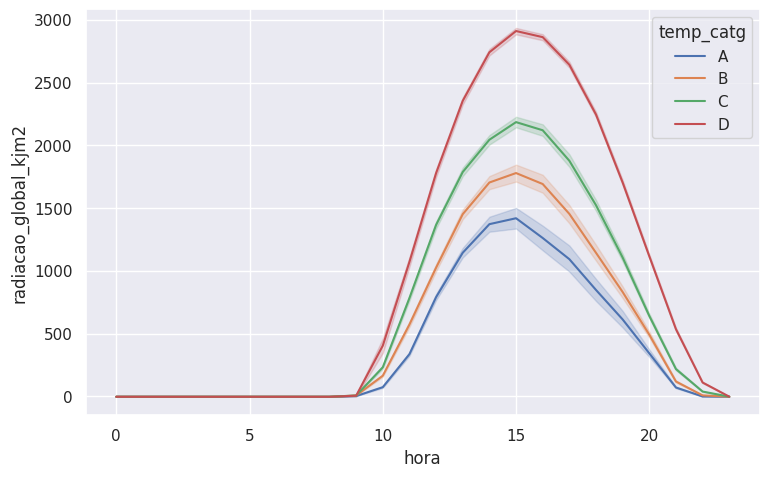

In [49]:
sns.lineplot(data=df_temp, x=df_temp["hora"], y=df_temp["radiacao_global_kjm2"], hue=df_temp["temp_catg"])

#### Hora com a umidade como `hue`

In [50]:
df_temp = df[[
    "hora", 
    "radiacao_global_kjm2", 
    "humidity"]]\
.fillna(0)

df_temp["hum_catg"] = create_category("humidity", df_temp)

[ 0.         59.66666667 75.66666667 87.66666667 99.        ]


<Axes: xlabel='hora', ylabel='radiacao_global_kjm2'>

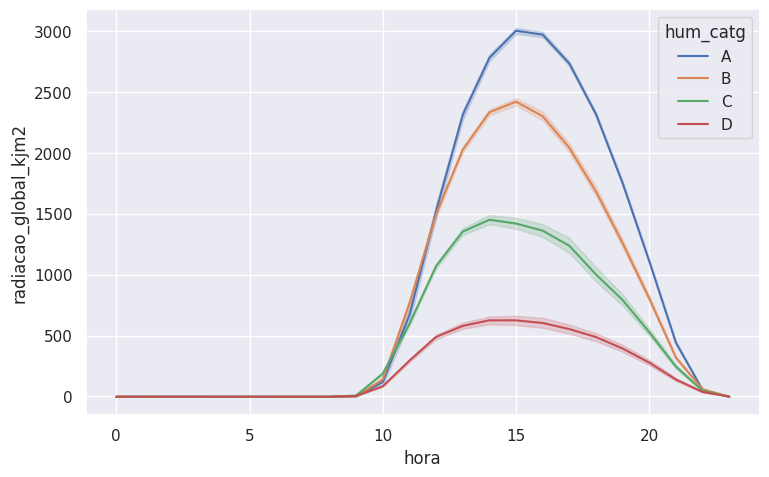

In [51]:
sns.lineplot(data=df_temp, x=df_temp["hora"], y=df_temp["radiacao_global_kjm2"], hue=df_temp["hum_catg"])

#### Relação linear entre radiação e vento 

<Axes: xlabel='vento_rajada_maxima_ms', ylabel='radiacao_global_kjm2'>

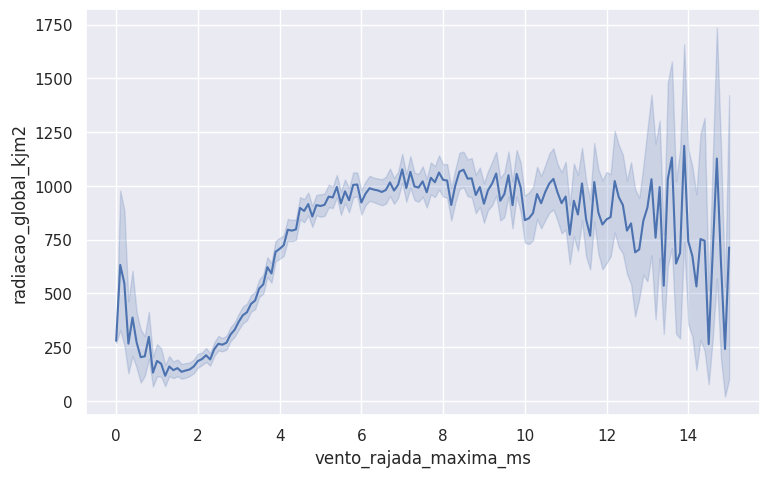

In [52]:
sns.lineplot(data=df, x=df["vento_rajada_maxima_ms"], y=df["radiacao_global_kjm2"])

<Axes: xlabel='humidity', ylabel='radiacao_global_kjm2'>

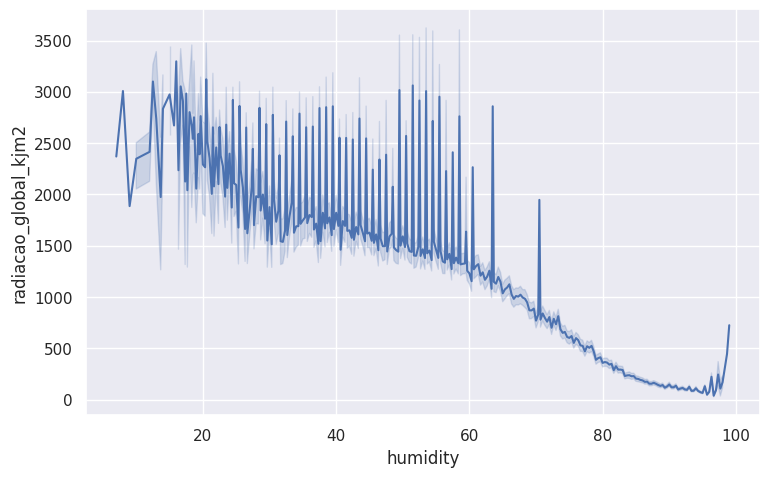

In [53]:
sns.lineplot(data=df, x=df["humidity"], y=df["radiacao_global_kjm2"])

### Conclusões

#### Desbalanceamento
O dataset possui uma quantidade razoável de nulos, quando falamos da coluna "alvo" radiação, que fica em torno de \~9.7%. Como não chega a ser um valor expressivo, podemos simplesmente remover os nulos dessa coluna. Em seguida, analisamos as estatisticas dos dados, como média, desvio padrão e quartis. O que foi percebido é um valor alto do desvio em relação a média, podendo indicar a presença de outliers. Entretanto, o dataset na verdade possui dados desbalanceados, tendo muitos valores negativos (~46%) na mesma faixa de valores, o que pode comppromenter uma futura previsão. Aqui podemos tratar esse desbalanceamento com algumas técnicas, como o undersampling, por exemplo. Iremos remover posteriormente, apenas para checar o comportamento dos dados quando plotamos.

Ainda falando de dados desbalanceados, temos também a categoria "vento", que contém um numero pequeno de registros acima do valor 15. Portanto, para fins de previsão, podemos remove-los.

Sobre a coluna de precipitação, temos valores zerados ou nulos quase em sua totalidade. Portanto, iremos remove-la do dataset.

#### Feature Engineering

No dataset, existem colunas que representam o mesmo conceito, e possuem medidas estatisticas (media, desvio) semelhantes. Portanto, aplicamos alguns métodos para "juntarmos" essas colunas semelhantes em uma só, como o caso das colunas de pressão atmosférica, umidade e temperatura.


#### Analise com datas

Para termos ma visão geral falando de séries temporais, agregamos os dados por ano, mes e horário, para tentar enxergar algum padrão.

##### Por ano
Agregando os dados por ano, notou-se um leve aumento de 2008 a 2019, com pequenas variações para menos entre esse período.

##### Por mes
Construindo um gráfico com dados agregados por mes, não houve nenhum ponto atípico. Os dados mostram uma maior incidência de radiação no início do ano (verão), com uma queda acentuada assim que deslocamos a coluna temporal até o meio do ano (outuno-inverno), com novo aumento da radiação assim que se aproxima do final do ano (primavera-verão).

##### Por hora
Assim como o plot por mês, não houve nenhum comportamento atípico ao esperado, tendo a faixa ~10h-17h a maior incidência de radição do dia, caindo bruscamente a partir das 20h.

##### Valores horários por outra colunas
Nessa análise, decidimos isolar as observações horárias por categorias (A, B, C e D) dentro de algumas colunas. Ou seja, utilizamos os quartis dessas colunas e categorizamos os valores. Ex: temperatura categoria A: de 0 a 15, categoria B: de 15 a 25, e assim por diante. As seguintes colunas foram utilzadas:

- **Vento**: Percebemos uma ligeira relação diretamente proporcional entre ventos fortes e maiores niveis de radiação, porém nada relevante.
- **Pressão atmosférica**: aqui tivemos um comportamento bem semelhante entre as categorias de pressão atmosférica, não havendo relevancia no nivel de radiação solar.
- **Temperatura**: no caso da temperatura, não houve comportamento ineserado, prevalecendo as altas temperaturas com incidência da radiação, com grande diferença (aproximadamente o dobro entre a categoria com maiores temperaturas e a categoria com as menores)
- **Umidade**: da mesma forma que a temperatura, também não houve nada diferente do previsto, com as baixas taxas de umidade tendo relação forte com altos valores de radiação solar, dessa vez de forma expressiva, com grandes diferenças.

##### Relação linear
Como ultima análise, decidimos verificar se existe uma relação linear entre alguma coluna e os valores de radiação. Como escolha, tivemos um resultado interessante utilzando o vento novamente. O gráfico mostra que o pico de radiação é atingido quando a rajada máxima de vento fica maior que 6 m/s, com variação desses valores conforme os valores aumentam. E para confirmar a relação inversamente proporcional entre umidade e a radiação, também colocamos em gráfico ambas as colunas, evidenciando esse comportamento. 
